# Hyper-parameter Tuning Workflow
Another technique very much worth noting is hyper-parameter tuning, which follows a similar structure to the pre-processor tuning but deals with selecting the best model training parameters for the given data.

Unfortunately there is no rigorous way to predict what parameters will be ideal for a given model or dataset, and thus training (and intuition built up over years of practice) is necessary. Still, we can have the computer run the tuning, even if we need to determine the value's ranges and what precisely to tune.

In [5]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('./*'); sys.path.append('..')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from trainer import Trainer
import pandas as pd
import os.path as p
import optuna

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d = '../sheet_data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from datasets.ClassificationSet import ClassificationSet
from models.SheetClassifier import SheetClassifier

# Use the pre-processed images we made in the pre-processing workflow
dataset = ClassificationSet(p.join(d, 'preprocessed_training_set'))
dummy_parameters = SheetClassifier().state_dict()
trainer = Trainer()

In [7]:
#=====
epochs = 30
#=====
results = pd.DataFrame([], columns=['lr', 'wd', 'bs', 'accuracy'])

def objective(trial, learning_rate:float=None, batch_size:float=None, weight_decay:float=None, record:bool=True, show:bool=False):
    lr = trial.suggest_float("lr", 1e-4, 1e-1) if not learning_rate else learning_rate
    batch_size = trial.suggest_categorical("batch_size", [100]) if not batch_size else batch_size
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1) if not weight_decay else weight_decay

    temp_model = SheetClassifier()
    temp_model.load_state_dict(dummy_parameters)

    trainer.run_experiment(temp_model, dataset, criterion=nn.CrossEntropyLoss,
                           learning_rate=lr, weight_decay=weight_decay, batch_size=batch_size,
                           epochs=epochs, show=show, train_shuffle=False, test_shuffle=False)
    trainer.evaluate_model(temp_model, show=show)

    if record: results.loc[len(results)] = [lr, batch_size, weight_decay, trainer.model_accuracy]
    return trainer.model_accuracy

In [8]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)

[I 2025-03-12 14:47:49,152] A new study created in memory with name: no-name-5699dfea-8043-4dbb-b6a8-297ae668b7a8
[I 2025-03-12 14:48:17,020] Trial 0 finished with value: 0.8650000095367432 and parameters: {'lr': 0.05492646904233975, 'batch_size': 100, 'weight_decay': 0.07152178474357823}. Best is trial 0 with value: 0.8650000095367432.
[I 2025-03-12 14:48:43,662] Trial 1 finished with value: 0.7549999952316284 and parameters: {'lr': 0.06031606126955723, 'batch_size': 100, 'weight_decay': 0.05449286946785972}. Best is trial 0 with value: 0.8650000095367432.
[I 2025-03-12 14:49:10,182] Trial 2 finished with value: 0.8700000047683716 and parameters: {'lr': 0.042423114453956585, 'batch_size': 100, 'weight_decay': 0.06459295236553494}. Best is trial 2 with value: 0.8700000047683716.
[I 2025-03-12 14:49:36,622] Trial 3 finished with value: 0.6225000023841858 and parameters: {'lr': 0.04381496240514299, 'batch_size': 100, 'weight_decay': 0.08917838234820016}. Best is trial 2 with value: 0.870

C:\Users\slayt\AppData\Local\Temp\ipykernel_21940\335759288.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\slayt\AppData\Local\Temp\ipykernel_21940\335759288.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)
C:\Users\slayt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\visualization\matplotlib\_parallel_coordinate.py:115: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(dim.range[0], dim.range[1])
C:\Users\slayt\AppData\Local\Temp\ipykernel_21940\335759288.py:3: ExperimentalWarning: plot_slice is experimental (suppor

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

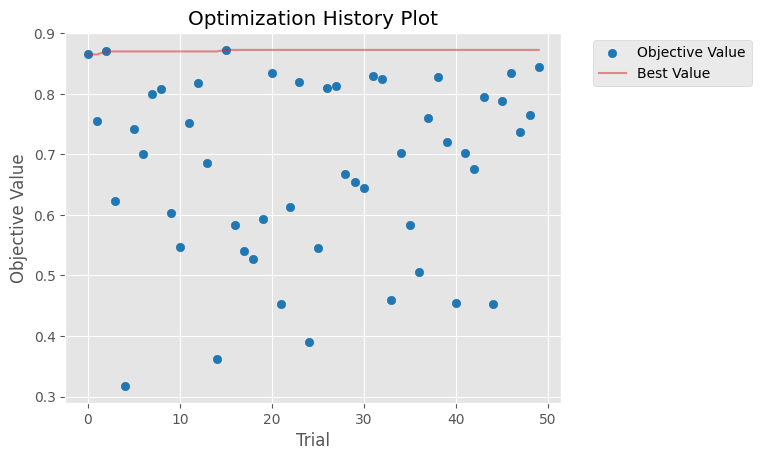

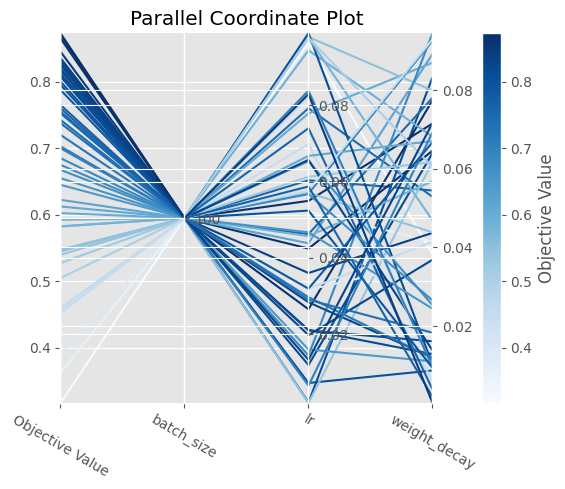

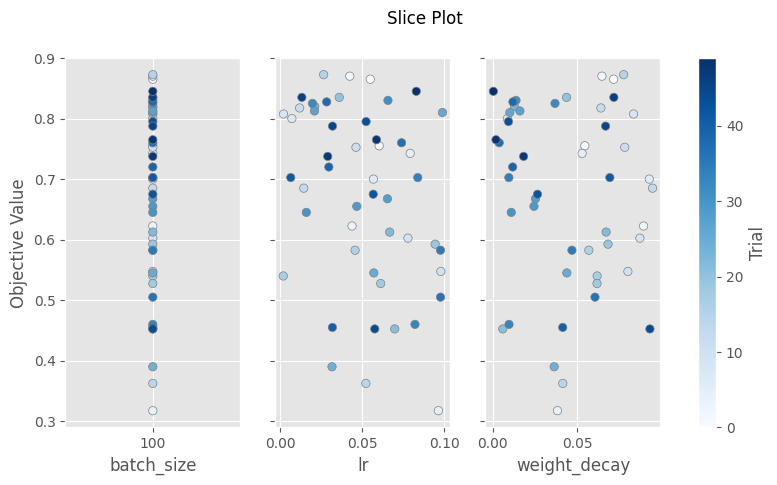

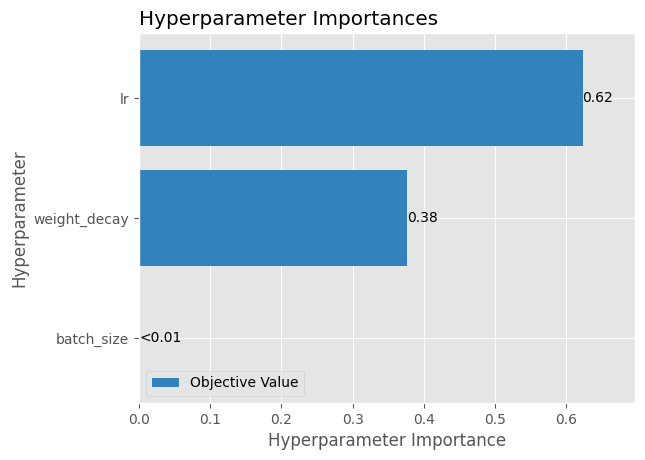

In [9]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
optuna.visualization.matplotlib.plot_slice(study, params=['lr', 'weight_decay', 'batch_size'])
optuna.visualization.matplotlib.plot_param_importances(study)

In [13]:
pd.to_pickle(study.best_params, './best_params.pkl')

# Utilizing Mixed Precision, LR Scheduling, and Model Pruning

In [16]:
lr, wd = study.best_params['lr'], study.best_params['weight_decay']

In [17]:
temp_model = SheetClassifier()
temp_model.load_state_dict(dummy_parameters)

trainer.run_experiment(temp_model, dataset, criterion=nn.CrossEntropyLoss,
                        learning_rate=lr, weight_decay=wd, batch_size=100,
                        mixed_precision=True, scheduler=True, pruning=False,
                        epochs=25, show=True, train_shuffle=False, test_shuffle=False)
trainer.evaluate_model(temp_model, show=True)

Epoch [1/25], Train Loss: 11.37, Accuracy: 0.70
Epoch [6/25], Train Loss: 0.49, Accuracy: 0.86
Epoch [11/25], Train Loss: 0.36, Accuracy: 0.86
Epoch [16/25], Train Loss: 0.21, Accuracy: 0.93
Epoch [21/25], Train Loss: 0.18, Accuracy: 0.95
Experiment Complete
[Evaluation over 4 Batches], Test Loss: 0.34, Accuracy: 0.88


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

In [18]:
temp_model = SheetClassifier()
temp_model.load_state_dict(dummy_parameters)

trainer.run_experiment(temp_model, dataset, criterion=nn.CrossEntropyLoss,
                        learning_rate=lr, weight_decay=wd, batch_size=10,
                        epochs=25, show=True, train_shuffle=False, test_shuffle=False)
trainer.evaluate_model(temp_model, show=True)

Epoch [1/25], Train Loss: 5.82, Accuracy: 0.63
Epoch [6/25], Train Loss: 0.88, Accuracy: 0.62
Epoch [11/25], Train Loss: 1.01, Accuracy: 0.60
Epoch [16/25], Train Loss: 3.40, Accuracy: 0.59
Epoch [21/25], Train Loss: 1.03, Accuracy: 0.62
Experiment Complete
[Evaluation over 40 Batches], Test Loss: 0.99, Accuracy: 0.47


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

# Results
As shown, using optimal hyper parameters leads to better training results (big surprise), and further using advanced training techniques such as learning rate scheduling and mixed precision tuning can improve model effectiveness even further in relatively few epochs.